In [1]:
import torch

In [2]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [7]:
excel_path = r"C:\Users\lenovo\Desktop\paper\Fault-Diagnosis\data\pre_data\dataset_split_0.xlsx"
df = pd.read_excel(excel_path, sheet_name = "train")
x = df.iloc[1,:-1]
y = df.iloc[1,-1]
print (y,x)

3 0       0.051875
1      -0.000783
2      -0.005469
3       0.002970
4       0.000835
          ...   
1019    0.004441
1020   -0.001134
1021   -0.013906
1022   -0.003267
1023   -0.037917
Name: 1, Length: 1024, dtype: float64


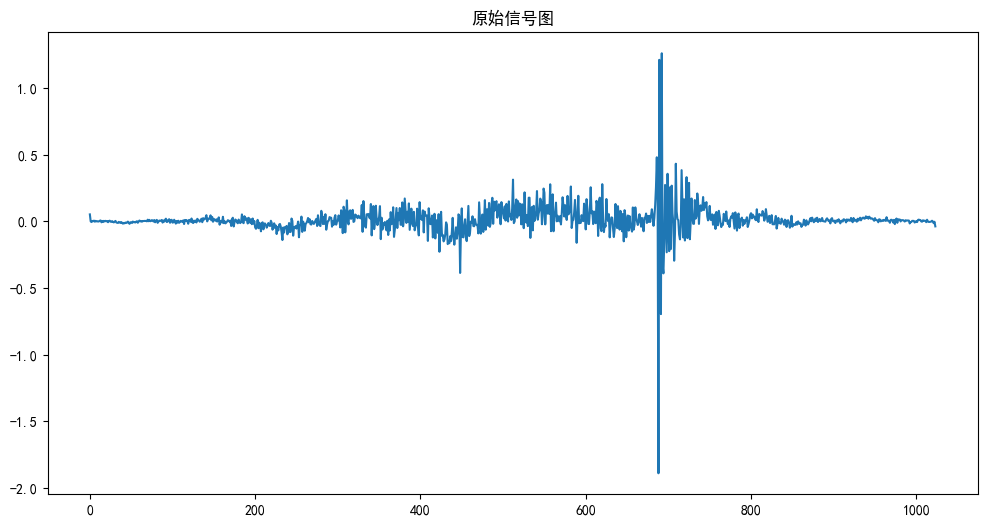

In [11]:
plt.figure(figsize = (12,6))
plt.title("原始信号图")
plt.plot(x)
plt.show()

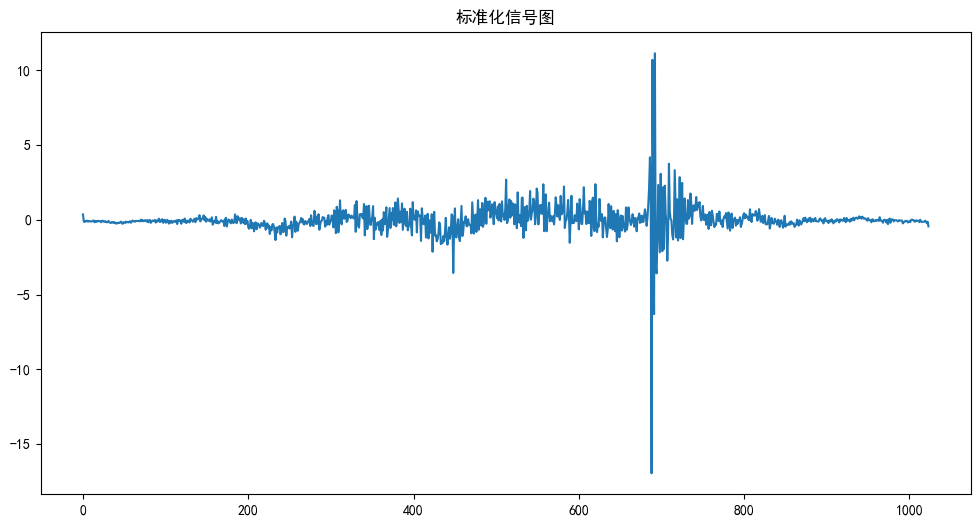

In [10]:
mean = np.mean(x)
std = np.std(x)
x_1 = (x - mean) / std

plt.figure(figsize = (12,6))
plt.title("标准化信号图")
plt.plot(x_1)
plt.show()

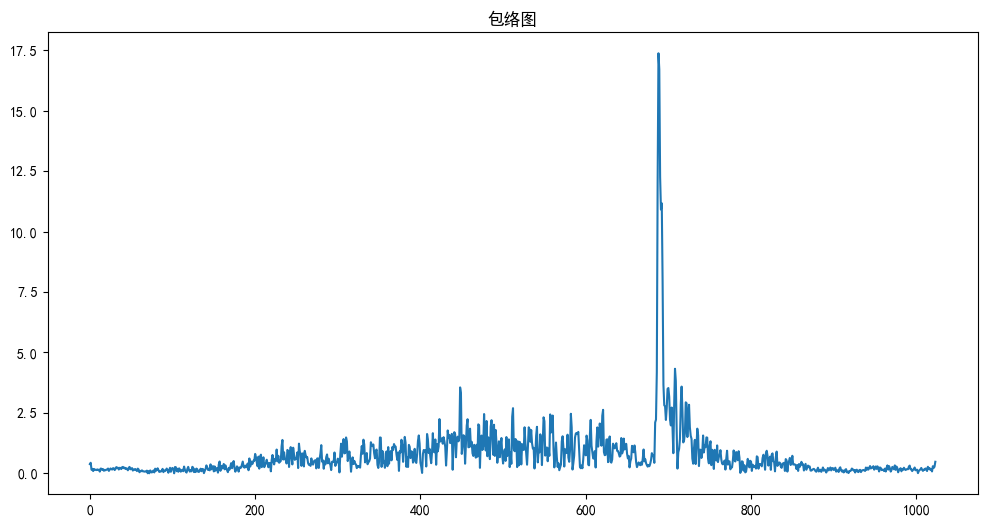

In [12]:
x_2 = np.abs(hilbert(x_1))
plt.figure(figsize = (12,6))
plt.title("包络图")
plt.plot(x_2)
plt.show()

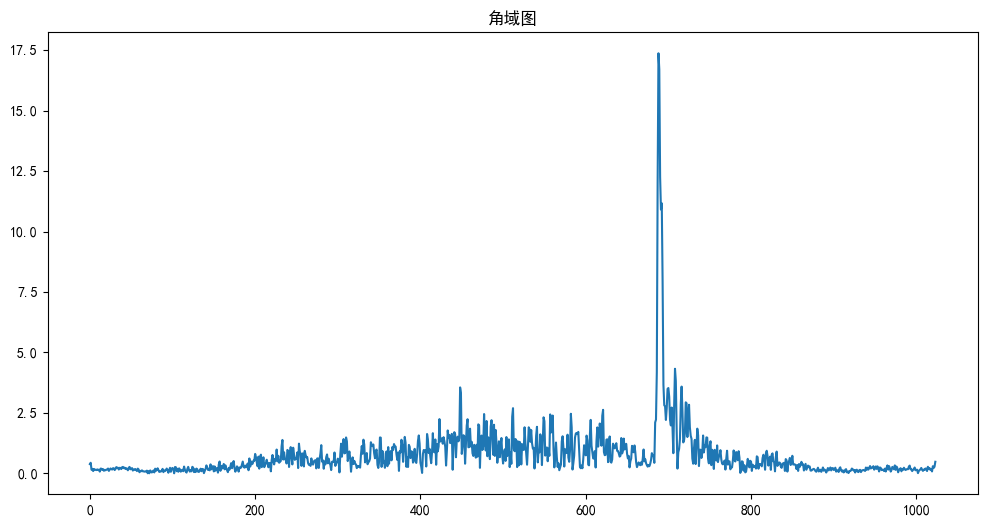

In [17]:
t_original = np.arange(len(x_2)) / 50000
rps = 600 / 60.0
theta_original = 360.0 * rps * t_original
theta_new = np.linspace(theta_original[0], theta_original[-1], 1024)

interp_angle_to_time = interp1d(theta_original, t_original, kind='linear', fill_value="extrapolate")
t_new = interp_angle_to_time(theta_new)

interp_time_to_signal = interp1d(t_original, x_2, kind='linear', fill_value="extrapolate")
x_3 = interp_time_to_signal(t_new)

plt.figure(figsize = (12,6))
plt.title("角域图")
plt.plot(x_3)
plt.show()

In [20]:
x_3

array([0.38726207, 0.44149162, 0.1523925 , ..., 0.22798099, 0.27577591,
       0.48237969])

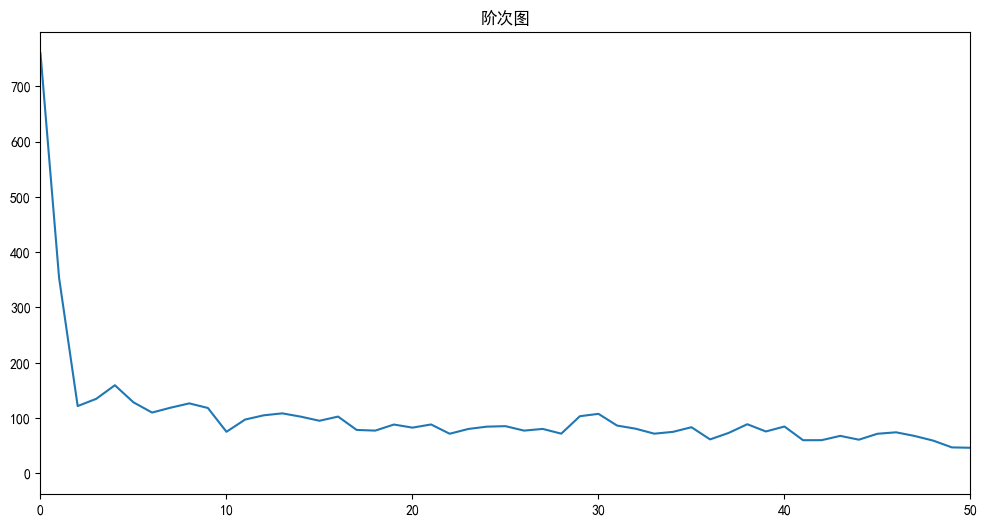

In [25]:
x_4 = np.abs(np.fft.rfft(x_3))
orders = np.arange(len(x_4))

plt.figure(figsize = (12,6))
plt.title("阶次图")
plt.plot(orders, x_4)
plt.xlim(0,50)
plt.show()

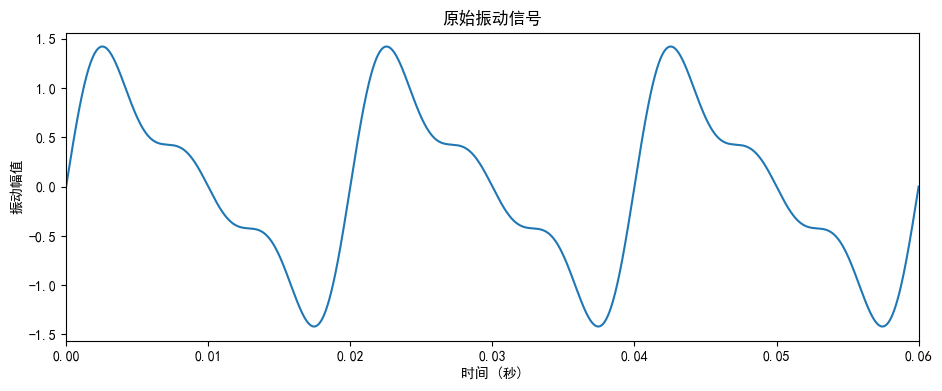

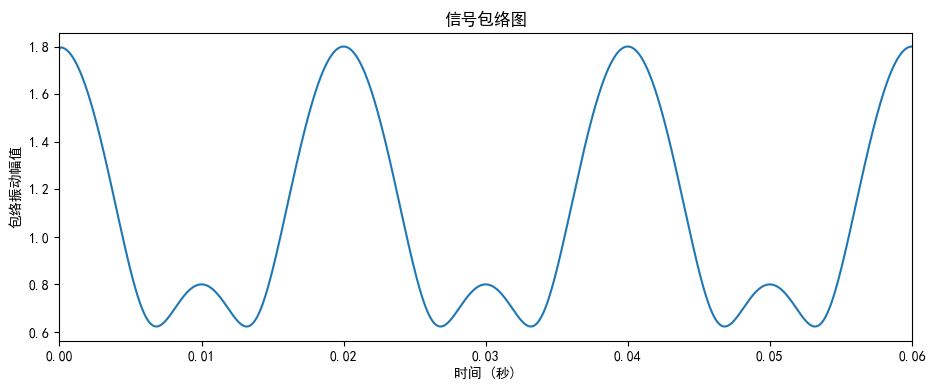

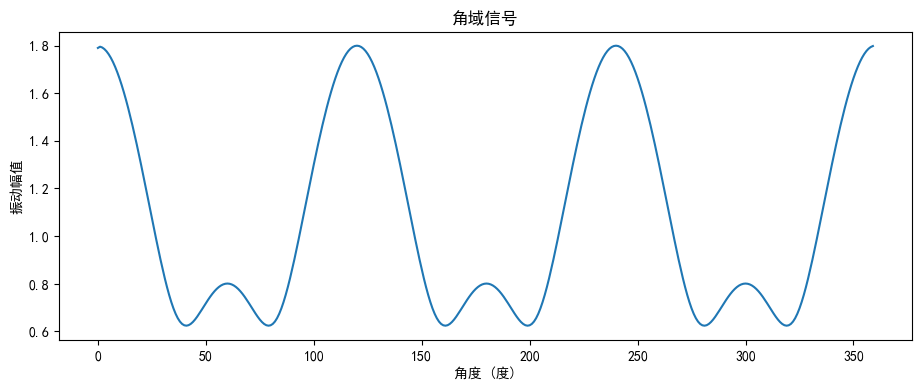

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy.signal import hilbert

# 设置Matplotlib中文显示
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# 模拟生成带谐波的振动信号
fs = 200000  # 采样频率
t = np.linspace(0, 1, fs)  # 1秒钟的数据

# 生成基频为50Hz的信号，并加入其谐波（100Hz、150Hz）
f_base = 50  # 基频 50Hz
f_harmonics = [100, 150]  # 100Hz 和 150Hz 谐波
amp_base = 1.0  # 基频幅值
amp_harmonics = [0.5, 0.3]  # 谐波幅值

# 振动信号 = 基频 + 谐波
vib = amp_base * np.sin(2 * np.pi * f_base * t) 
for i, f in enumerate(f_harmonics):
    vib += amp_harmonics[i] * np.sin(2 * np.pi * f * t)

# 设置固定转速：例如1000RPM，转换为Hz
speed_fre = 1000 / 60  # 转速 1000 RPM 转换为Hz

# 生成等时间间隔的时间序列
angleStep = 1  # 角度步长
total_angle = 360  # 总角度
EqualAngle = np.arange(0, total_angle, angleStep)  # 角度范围
# 包络变换
H = np.abs(hilbert(vib) - np.mean(vib))
# 计算时间点
EqualAngleTime = EqualAngle * (1 / speed_fre / 360)

# 用等角度间隔的时间点对振动信号重新采样
FunctionV = interp1d(t, H, kind='cubic', fill_value="extrapolate")
EqualAngleVib = FunctionV(EqualAngleTime)

# 绘制原始信号（基频 + 谐波）
plt.figure(figsize=(11, 4))
plt.plot(t, vib)
plt.title('原始振动信号')
plt.xlabel('时间 (秒)')
plt.ylabel('振动幅值')
plt.xlim(0,0.06)
plt.show()

# 绘制信号的包络图
plt.figure(figsize=(11, 4))
plt.plot(t, H)
plt.title('信号包络图')
plt.xlabel('时间 (秒)')
plt.ylabel('包络振动幅值')
plt.xlim(0,0.06)
plt.show()

# 绘制角域信号
plt.figure(figsize=(11, 4))
plt.plot(EqualAngle, EqualAngleVib)
plt.title('角域信号')
plt.xlabel('角度 (度)')
plt.ylabel('振动幅值')
plt.show()

In [76]:
# 对重采样后的信号进行FFT变换
VibFft = np.abs(fft(EqualAngleVib)) * 2 / len(EqualAngleVib)
VibFftHalf = VibFft[1:int(np.round(len(EqualAngleVib) / 2))]
order = np.arange(0, len(EqualAngleVib)) * (1 / angleStep * 360) / len(EqualAngleVib)
orderHalf = order[1:int(np.round(len(EqualAngleVib) / 2))]

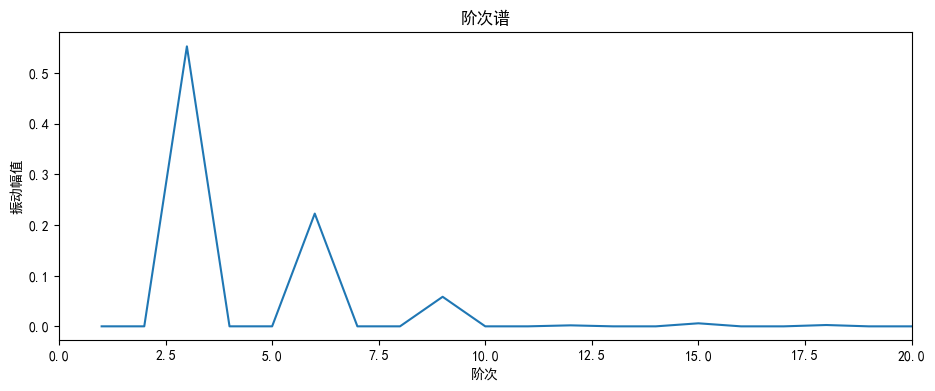

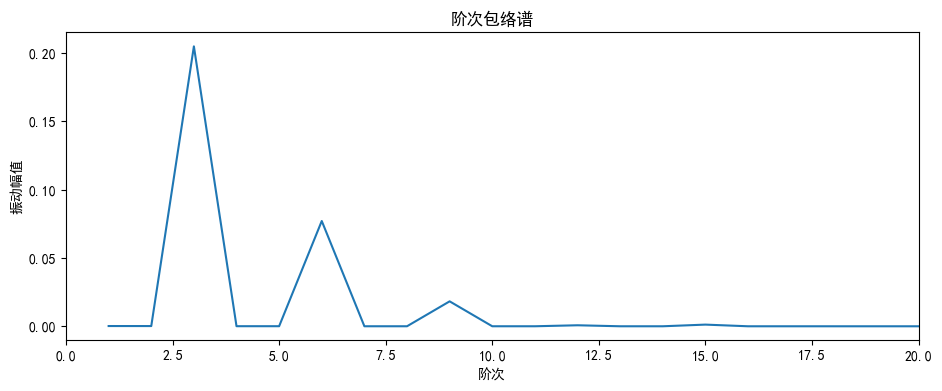

In [77]:
# 绘制阶次谱
plt.figure(figsize=(11, 4))
plt.plot(orderHalf, VibFftHalf)
plt.title('阶次谱')
plt.xlabel('阶次')
plt.ylabel('振动幅值')
plt.xlim(0, 20)
plt.show()

# 包络变换后的信号
H_filter = np.abs(hilbert(EqualAngleVib) - np.mean(EqualAngleVib))
# 如果在包络上直接做 FFT 而没有去掉直流，会在频谱中出现一个很强的 0 阶（直流）分量，
# 严重的时候会沾满整个频谱图底部，使得其他阶次分量难以观察。去掉平均值能把直流分量移除，让谱图更干净，突出有用的特征。

# 对包络信号进行FFT变换
HP = np.abs(fft(H_filter - np.mean(H_filter))) * 2 / len(EqualAngleVib)
HP_half = HP[1:int(np.round(len(EqualAngleVib) / 2))]

# 绘制阶次包络谱
plt.figure(figsize=(11, 4))
plt.plot(orderHalf, HP_half)
plt.title('阶次包络谱')
plt.xlabel('阶次')
plt.ylabel('振动幅值')
plt.xlim(0, 20)
plt.show()

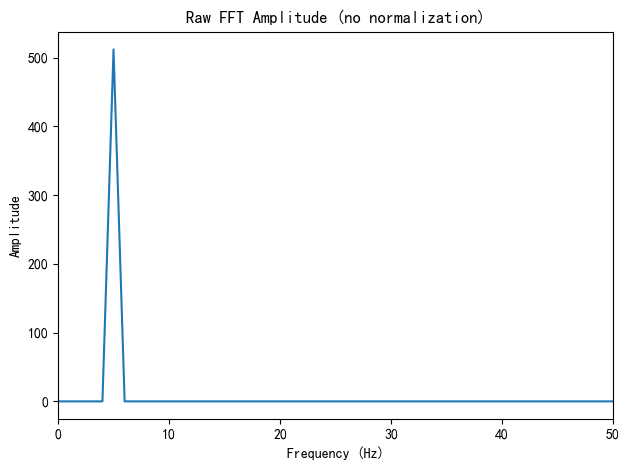

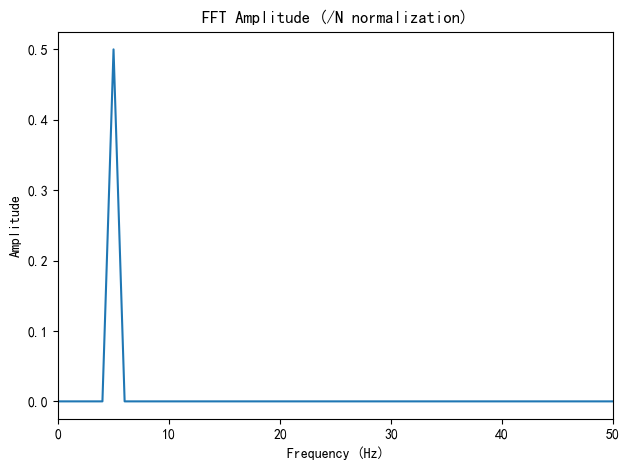

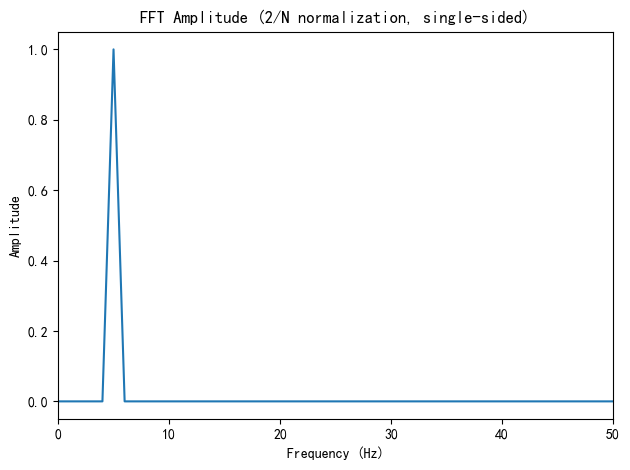

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1024
t = np.linspace(0, 1, N, endpoint=False)
f0 = 5  # Signal frequency in Hz

# Generate a simple sine wave
x = np.sin(2 * np.pi * f0 * t)

# Compute FFT in three ways
X_raw = np.fft.fft(x)
X_norm = X_raw / N
X_single_sided = 2 * X_norm

# Frequency axis (positive frequencies)
freqs = np.fft.fftfreq(N, d=1/N)
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]

# Single-sided amplitude spectra
amp_raw = np.abs(X_raw[pos_mask])
amp_norm = np.abs(X_norm[pos_mask])
amp_single_sided = np.abs(X_single_sided[pos_mask])

# Plot raw FFT amplitude
plt.figure()
plt.plot(freqs_pos, amp_raw)
plt.title("Raw FFT Amplitude (no normalization)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,50)
plt.tight_layout()
plt.show()

# Plot FFT amplitude with /N normalization
plt.figure()
plt.plot(freqs_pos, amp_norm)
plt.title("FFT Amplitude (/N normalization)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,50)
plt.tight_layout()
plt.show()

# Plot FFT amplitude with /N and *2 (single-sided compensation)
plt.figure()
plt.plot(freqs_pos, amp_single_sided)
plt.title("FFT Amplitude (2/N normalization, single-sided)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,50)
plt.tight_layout()
plt.show()
